# Ingeniería de Características (Feature Engineering)

## Fase de Preparación de los Datos – Metodología CRISP-ML

En esta sección se lleva a cabo la fase de **Ingeniería de Características**, cuyo objetivo es transformar los datos crudos en un conjunto de variables más informativas, balanceadas y adecuadas para el aprendizaje automático.

Los objetivos específicos de esta fase son:
- Crear nuevas características que aporten información relevante para mejorar el rendimiento de los modelos.
- Mitigar el riesgo de características sesgadas y acelerar la convergencia de algunos algoritmos.
- Reducir la complejidad del conjunto de datos mediante técnicas de selección y extracción de características.

In [9]:
# Carga de librerias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [7]:
# -----------------------------
# 0) Descarga del dataset (macOS)
# -----------------------------

# Parte 1
!curl -L -o GroceryDataset_part1.tar.gz https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part1.tar.gz
!tar -xzf GroceryDataset_part1.tar.gz

# Parte 2
!curl -L -o GroceryDataset_part2.tar.gz https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz
!tar -xzf GroceryDataset_part2.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1442M  100 1442M    0     0  24.3M      0  0:00:59  0:00:59 --:--:-- 31.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1460M  100 1460M    0     0  23.8M      0  0:01:01  0:01:01 --:--:-- 26.2M


In [12]:
!tar -xzf GroceryDataset_part1.tar.gz
!tar -xzf GroceryDataset_part2.tar.gz

#print("Contenido de la carpeta GroceryDataset:")
#list(Path("GroceryDataset").iterdir())

In [16]:
print("Estructura del dataset (nivel 1):")

base_dirs = [
    "ShelfImages",
    "ProductImages",
    "BrandImages",
    "ProductImagesFromShelves",
    "BrandImagesFromShelves"
]

for d in base_dirs:
    p = Path(d)
    if p.exists():
        n_imgs = sum(1 for f in p.rglob("*") if f.suffix.lower() in {".jpg", ".jpeg", ".png"})
        print(f"- {d}/  (imágenes: {n_imgs})")

image_dir = Path("ShelfImages")

all_imgs = sorted([p for p in image_dir.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])

print("Ejemplos de imágenes:")
print([p.name for p in all_imgs[:10]])
print("Total de imágenes encontradas:", len(all_imgs))

Estructura del dataset (nivel 1):
- ShelfImages/  (imágenes: 354)
- ProductImages/  (imágenes: 3701)
- BrandImages/  (imágenes: 3701)
- ProductImagesFromShelves/  (imágenes: 13184)
- BrandImagesFromShelves/  (imágenes: 2744)
Ejemplos de imágenes:
['C1_P01_N1_S2_1.JPG', 'C1_P01_N1_S2_2.JPG', 'C1_P01_N1_S3_1.JPG', 'C1_P01_N1_S3_2.JPG', 'C1_P01_N1_S5_1.JPG', 'C1_P01_N2_S2_1.JPG', 'C1_P01_N2_S3_1.JPG', 'C1_P01_N2_S4_1.JPG', 'C1_P01_N3_S2_1.JPG', 'C1_P01_N3_S3_1.JPG']
Total de imágenes encontradas: 354


## 1. Estructura del conjunto de datos

El conjunto de datos contiene imágenes de anaqueles y productos, así como anotaciones
que describen la ubicación y clase de los productos detectados.

In [31]:
base_dirs = [
    "ShelfImages",
    "ProductImages",
    "BrandImages",
    "ProductImagesFromShelves",
    "BrandImagesFromShelves"
]

print("Estructura del dataset:")
for d in base_dirs:
    p = Path(d)
    if p.exists():
        n_imgs = sum(1 for f in p.rglob("*") if f.suffix.lower() in {".jpg", ".jpeg", ".png"})
        print(f"- {d}/ (imágenes: {n_imgs})")

Estructura del dataset:
- ShelfImages/ (imágenes: 354)
- ProductImages/ (imágenes: 3701)
- BrandImages/ (imágenes: 3701)
- ProductImagesFromShelves/ (imágenes: 13184)
- BrandImagesFromShelves/ (imágenes: 2744)


In [33]:
DATA_DIR = Path("ShelfImages")
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

image_paths = sorted([p for p in DATA_DIR.rglob("*") if p.suffix.lower() in exts])

print(f"Número total de imágenes en ShelfImages: {len(image_paths)}")
image_paths[:5]

Número total de imágenes en ShelfImages: 354


[PosixPath('ShelfImages/C1_P01_N1_S2_1.JPG'),
 PosixPath('ShelfImages/C1_P01_N1_S2_2.JPG'),
 PosixPath('ShelfImages/C1_P01_N1_S3_1.JPG'),
 PosixPath('ShelfImages/C1_P01_N1_S3_2.JPG'),
 PosixPath('ShelfImages/C1_P01_N1_S5_1.JPG')]

In [34]:
ANN_FILE = Path("annotations.csv")

if not ANN_FILE.exists():
    !curl -L -o annotations.csv https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv

cols = ["image_name", "x_i", "y_i", "w_i", "h_i", "b_i"]
df = pd.read_csv(ANN_FILE, names=cols)

df["bbox_area"] = df["w_i"] * df["h_i"]

print("Total de anotaciones:", len(df))
print("Imágenes únicas:", df["image_name"].nunique())
print("Clases únicas:", df["b_i"].nunique())

df.head()

Total de anotaciones: 13184
Imágenes únicas: 354
Clases únicas: 11


,image_name,x_i,y_i,w_i,h_i,b_i,bbox_area
0,C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0,2429280
1,C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0,1669120
2,C1_P01_N1_S2_1.JPG,24,872,268,1264,0,338752
3,C1_P01_N1_S2_1.JPG,280,1568,532,1944,0,1034208
4,C1_P01_N1_S2_1.JPG,292,872,544,1248,0,678912


## 2. Análisis de valores faltantes

In [35]:
df.isnull().sum()

image_name    0
x_i           0
y_i           0
w_i           0
h_i           0
b_i           0
bbox_area     0
dtype: int64

## 3. Análisis univariante

Se analizan las distribuciones individuales de las variables más relevantes.

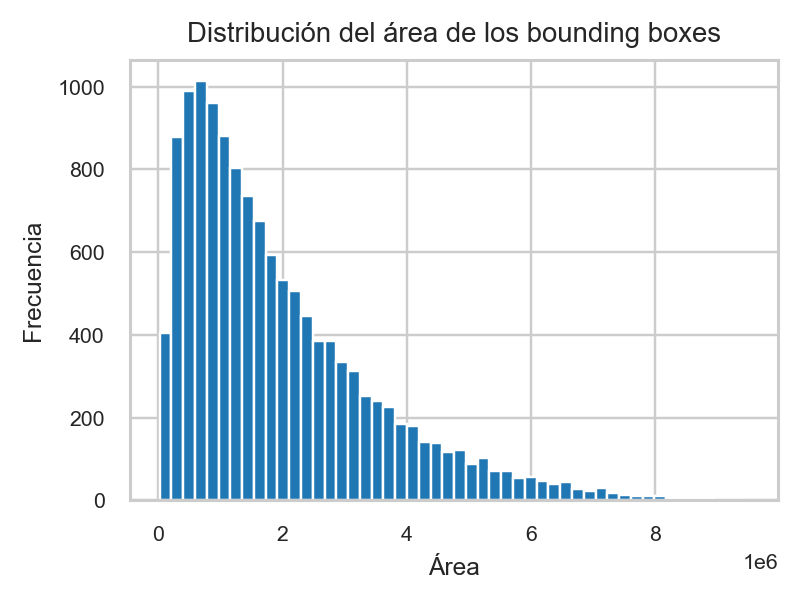

In [36]:
plt.hist(df["bbox_area"], bins=50)
plt.title("Distribución del área de los bounding boxes")
plt.xlabel("Área")
plt.ylabel("Frecuencia")
plt.show()

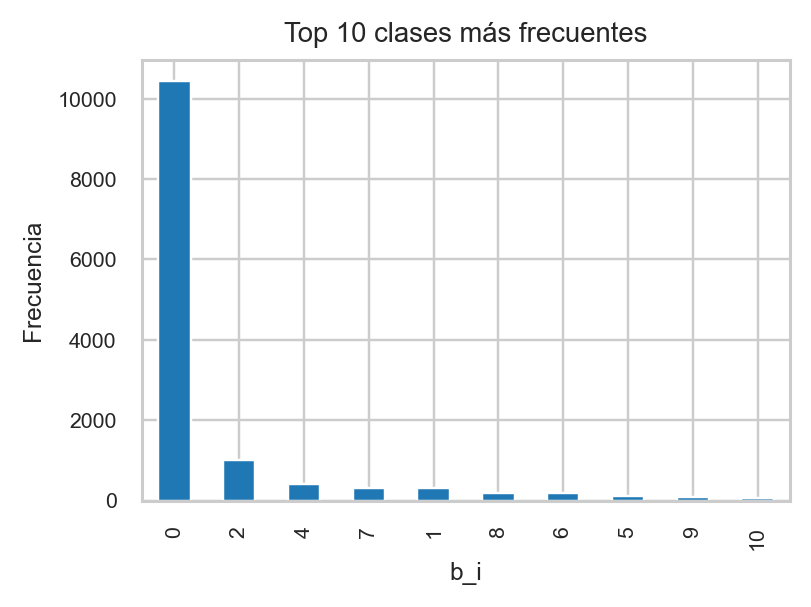

In [37]:
df["b_i"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 clases más frecuentes")
plt.ylabel("Frecuencia")
plt.show()

In [45]:
features_scaled[numeric_cols].corr()

,num_productos,area_promedio_bbox,densidad_productos
num_productos,1.000000,-0.163493,0.722982
area_promedio_bbox,-0.163493,1.000000,-0.618555
densidad_productos,0.722982,-0.618555,1.000000


## 4. Conclusiones del EDA

- No se identifican valores faltantes estructurales.
- Existe un desbalance entre clases de productos.
- Las áreas de los bounding boxes presentan distribuciones sesgadas.
- Es necesario crear variables agregadas por imagen para mejorar la generalización.

# Ingeniería de Características (Feature Engineering)

## Fase de Preparación de los Datos – CRISP-ML

En esta sección se transforman los datos crudos en un conjunto de características más informativas,
mitigando sesgos y preparando los datos para el aprendizaje automático.

## 5. Variables base

In [25]:
df.columns

Index(['image_name', 'x_i', 'y_i', 'w_i', 'h_i', 'b_i', 'bbox_area'], dtype='object')

In [26]:
# Conteo de productos por imagen
products_per_image = (
    df.groupby("image_name")
      .size()
      .reset_index(name="num_productos")
)

products_per_image.head()

,image_name,num_productos
0,C1_P01_N1_S2_1.JPG,10
1,C1_P01_N1_S2_2.JPG,10
2,C1_P01_N1_S3_1.JPG,15
3,C1_P01_N1_S3_2.JPG,15
4,C1_P01_N1_S5_1.JPG,25


In [38]:
avg_bbox_area = (
    df.groupby("image_name")["bbox_area"]
      .mean()
      .reset_index(name="area_promedio_bbox")
)

avg_bbox_area.head()

,image_name,area_promedio_bbox
0,C1_P01_N1_S2_1.JPG,1.253717e+06
1,C1_P01_N1_S2_2.JPG,3.083226e+06
2,C1_P01_N1_S3_1.JPG,2.344588e+06
3,C1_P01_N1_S3_2.JPG,1.487116e+06
4,C1_P01_N1_S5_1.JPG,1.477490e+06


In [39]:
features_img = products_per_image.merge(avg_bbox_area, on="image_name")

features_img["densidad_productos"] = (
    features_img["num_productos"] / features_img["area_promedio_bbox"]
)

features_img.head()

,image_name,num_productos,area_promedio_bbox,densidad_productos
0,C1_P01_N1_S2_1.JPG,10,1.253717e+06,0.000008
1,C1_P01_N1_S2_2.JPG,10,3.083226e+06,0.000003
2,C1_P01_N1_S3_1.JPG,15,2.344588e+06,0.000006
3,C1_P01_N1_S3_2.JPG,15,1.487116e+06,0.000010
4,C1_P01_N1_S5_1.JPG,25,1.477490e+06,0.000017


### Densidad de productos por imagen

La densidad de productos se define como la relación entre el número de productos detectados y el área promedio ocupada. Esta característica permite comparar imágenes independientemente de su escala y mitiga el sesgo de imágenes con diferentes resoluciones.

In [41]:
!pip install -q scikit-learn

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = ["num_productos", "area_promedio_bbox", "densidad_productos"]

features_scaled = features_img.copy()
features_scaled[numeric_cols] = scaler.fit_transform(features_img[numeric_cols])

features_scaled.head()

,image_name,num_productos,area_promedio_bbox,densidad_productos
0,C1_P01_N1_S2_1.JPG,0.000000,0.219952,0.037047
1,C1_P01_N1_S2_2.JPG,0.000000,0.718914,0.000000
2,C1_P01_N1_S3_1.JPG,0.031646,0.517465,0.024691
3,C1_P01_N1_S3_2.JPG,0.031646,0.283607,0.053566
4,C1_P01_N1_S5_1.JPG,0.094937,0.280982,0.107060


#### Normalización y mitigación de sesgo

Se aplicó normalización Min–Max a las variables numéricas con el objetivo de garantizar
que todas tengan un impacto equitativo en los algoritmos de aprendizaje automático.
Esta técnica es especialmente relevante para modelos sensibles a la escala y contribuye
a mejorar la convergencia durante el entrenamiento.

Adicionalmente, la normalización ayuda a mitigar sesgos derivados de diferencias
en magnitudes entre las características originales.

### Selección de características mediante métodos de filtrado

Se aplicó un **umbral de varianza** con el objetivo de eliminar características con baja
variabilidad, ya que este tipo de variables aporta poca información al modelo y
aumenta innecesariamente la complejidad computacional.

Adicionalmente, se analizó la **correlación entre variables numéricas** para identificar
características redundantes. La eliminación de variables altamente correlacionadas
permite reducir el requerimiento de almacenamiento y mejorar la interpretabilidad
del modelo.

In [43]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_sel = selector.fit_transform(features_scaled[numeric_cols])

X_sel.shape

(354, 3)

### Extracción de características mediante PCA

Se aplicó **Análisis de Componentes Principales (PCA)** como técnica de extracción de
características, con el objetivo de reducir la dimensionalidad del conjunto de datos
manteniendo la mayor parte de la varianza explicada.

Esta técnica permite acelerar el tiempo de entrenamiento de modelos posteriores
y reducir la complejidad, al transformar las variables originales en un conjunto
más compacto de componentes no correlacionados.

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(features_scaled[numeric_cols])

X_pca.shape

(354, 2)

## Conclusiones – Preparación de los Datos (CRISP-ML)

En el contexto de la metodología CRISP-ML, la fase de Preparación de los Datos permitió
transformar los datos crudos en un conjunto de características más informativas,
normalizadas y menos sesgadas.

Las técnicas de ingeniería, selección y extracción de características reducen la
complejidad del problema y sientan las bases para un modelado posterior más estable,
eficiente y generalizable.